# Inverse Kinematics for a robot arm in Mujoco

In [2]:
import numpy as np
import mujoco
import mujoco.viewer as viewer
import mediapy as media

## Load Model

In [3]:
# load model
xml = "../mujoco_menagerie/universal_robots_ur5e/scene.xml" # add your path
model = mujoco.MjModel.from_xml_path(xml)
data = mujoco.MjData(model)
renderer = mujoco.Renderer(model)

## Setup Camera

In [4]:
# Make a new camera, move it to a closer distance.
camera = mujoco.MjvCamera()
mujoco.mjv_defaultFreeCamera(model, camera)
camera.distance = 1

## Get a test point for my end effector

Target => [0.492 0.134 0.588]


""

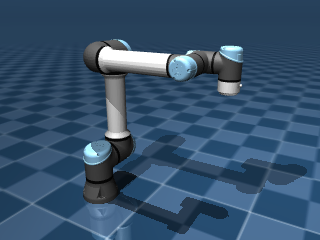

In [8]:
#put random position of the joints
pi = np.pi
data.qpos = [3*pi/2, -pi/2, pi/2, 3*pi/2, 3*pi/2, 0]

# inititial joint position
qpos0 = data.qpos.copy()

# Step the simulation.
mujoco.mj_forward(model, data)

# get the end effector position in cartesian variables
target = data.body('wrist_3_link').xpos
print("Target =>",target)

#plot robot
renderer.update_scene(data, camera)
media.show_image(renderer.render())

In [101]:
#limits of the angles of qpos
for j in range(len(data.qpos)):
    print(data.qpos[j])
    print(data.jnt(j).name,"limit =>", model.jnt_range[j][0], "\n")

-1.5748780972641434
shoulder_pan_joint limit => -6.28319 

-0.3785931171707605
shoulder_lift_joint limit => -6.28319 

-0.911766907828286
elbow_joint limit => -3.1415 

1.3618330551887325
wrist_1_joint limit => -6.28319 

4.517466259212579e-17
wrist_2_joint limit => -6.28319 

-1.243274959979862e-17
wrist_3_joint limit => -6.28319 



Manual
Desire point [0.492 0.134 0.588]


""

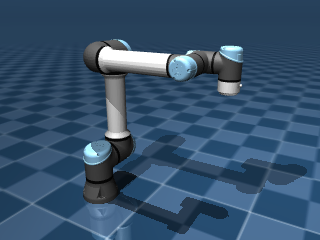

newton-gauss
result point [0.49680124 0.13197328 0.59702751]


""

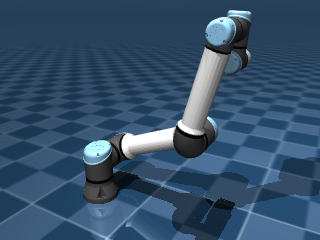

In [100]:
def check_joint_limits(q):
    for i in range(len(q)):
        if model.jnt_range[i][0] > q[i] :
            q[i] = model.jnt_range[i][0]
        
        if model.jnt_range[i][1] < q[i] :
            q[i] = model.jnt_range[i][1]
            

def gradient_descent_ik(model, data, body_id, goal_pose, init_q, step_size, tol, alpha, jacp, jacr):
    data.qpos = init_q
    mujoco.mj_forward(model, data)
    current_pose = data.body('wrist_3_link').xpos
    
    error = np.subtract(goal_pose, current_pose)
    
    while (np.linalg.norm(error) >= tol):
        #calculate jacobians
        mujoco.mj_jac(model, data, jacp, jacr, goal_pose, body_id)
        #calculate gradient
        grad = alpha * jacp.T @ error
        # next step
        data.qpos += step_size * grad
        # check limits
        check_joint_limits(data.qpos)
        #compute forward kinematics
        mujoco.mj_forward(model, data) 
        # calculate new error
        error = np.subtract(goal_pose, data.body('wrist_3_link').xpos)        

    
# Init variables.
body_id = model.body('wrist_3_link').id
jacp = np.zeros((3, model.nv)) #translation jacobian
jacr = np.zeros((3, model.nv)) #rotational jacobian
goal_pose = [0.49, 0.13, 0.59]
step_size = 0.5
tol = 0.01
alpha = 0.5
init_q = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
# init_q = qpos0

#get desire point
mujoco.mj_resetDataKeyframe(model, data, 1)
gradient_descent_ik(model, data, body_id, goal_pose, init_q, step_size, tol, alpha, jacp, jacr)

result = data.qpos.copy()

print("Manual")
data.qpos = qpos0
mujoco.mj_forward(model, data)
print("Desire point", test_point)
renderer.update_scene(data, camera)
media.show_image(renderer.render())

print("newton-gauss")
data.qpos = result
mujoco.mj_forward(model, data)
result_point = data.body('wrist_3_link').xpos
print('result point', result_point)
renderer.update_scene(data, camera)
media.show_image(renderer.render())